# Convolutional Neural Networks with Trasfer Learning

In [0]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np 
import seaborn as sn
import pandas  as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import ResNet50, MobileNetV2 # Modelos pre-entrenados
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Generador de imagenes para aumentacion de datos
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dropout, BatchNormalization # Metodos de regularizacion
from tensorflow.keras.layers import Input,Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten

import os
tf.logging.set_verbosity(tf.logging.INFO)

# habilitar eager execution
tf.enable_eager_execution()

%matplotlib inline

## Import Data

In [0]:
class DataLoader():
    """Load data MNIST """
    def __init__(self):
      
        # Download data
        (self.X_train, self.y_train),(self.X_test,self.y_test)= tf.keras.datasets.cifar10.load_data()
        
        # Preprocessing
        self.X_train = self.X_train.reshape(-1, 32, 32, 3).astype(np.float32)/255.0 # Debe ser de la forma [batch, H, W, num_canales]
        self.X_test  = self.X_test.reshape(-1, 32, 32, 3).astype(np.float32)/255.0
        self.y_train=self.y_train.astype(np.int32) 
        self.y_test=self.y_test.astype(np.int32)
        
    def get_batch(self,batch_size):
        # Muestreo aleatorio de los datos de la forma [0, stop, size]
        index=np.random.randint(0, self.X_train.shape[0], batch_size)
        return self.X_train[index,:], self.y_train[index]

In [3]:
data=DataLoader()
print(f'Forma de la entrada: {data.X_train.shape}')
print(f'Forma de la salida:  {data.y_train.shape}')

Forma de la entrada: (50000, 32, 32, 3)
Forma de la salida:  (50000, 1)


### Image Data Generator

In [0]:
datagen = ImageDataGenerator(rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest')

In [0]:
# Aplico la aumentacion de datos
datagen.fit(data.X_train)

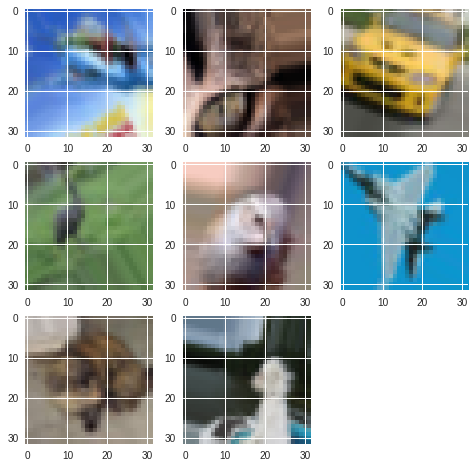

In [13]:

plt.figure(figsize=(8,8))

for x_batch, y_batch in datagen.flow(data.X_train, data.y_train, batch_size=9):
    for i in range (1,9):
        plt.subplot(3,3,i)
        plt.imshow(x_batch[i])
    break
    
plt.show()

## Convolutional Neural Network Model 

### Sequential 

In [0]:
model =Sequential()
model.add(Conv2D(32,(3,3),strides= (1,1), activation = 'relu', input_shape= (32,32,3)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3,3), strides=(1,1), activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3,3),strides=(1,1), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(GlobalAveragePooling2D()) # Flatten vector 
model.add(Dense(1024,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, activation='softmax'))

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 26, 26, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 128)       0         
__________

In [0]:
model.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
training = model.fit_generator(datagen.flow(data.X_train, data.y_train, batch_size= 64, shuffle= True),
                                   steps_per_epoch=data.X_train.shape[0]//64,
                                   epochs = 50,
                                   validation_data= (data.X_test,data.y_test))

Epoch 1/50
781/781 [==============================] - 49s 62ms/step - loss: 0.9785 - acc: 0.6567 - val_loss: 1.0249 - val_acc: 0.6483
Epoch 2/50
781/781 [==============================] - 50s 64ms/step - loss: 0.9546 - acc: 0.6667 - val_loss: 1.1952 - val_acc: 0.5935
Epoch 3/50
781/781 [==============================] - 49s 63ms/step - loss: 0.9335 - acc: 0.6729 - val_loss: 1.1964 - val_acc: 0.6047
Epoch 4/50
781/781 [==============================] - 48s 61ms/step - loss: 0.9170 - acc: 0.6793 - val_loss: 1.0792 - val_acc: 0.6453
Epoch 5/50
781/781 [==============================] - 48s 61ms/step - loss: 0.8977 - acc: 0.6848 - val_loss: 1.0135 - val_acc: 0.6559
Epoch 6/50
781/781 [==============================] - 47s 60ms/step - loss: 0.8806 - acc: 0.6927 - val_loss: 1.0497 - val_acc: 0.6430
Epoch 7/50
781/781 [==============================] - 47s 61ms/step - loss: 0.8674 - acc: 0.6968 - val_loss: 0.9396 - val_acc: 0.6836
Epoch 8/50
781/781 [==============================] - 48s 61ms

In [18]:
loss, acc= model.evaluate(data.X_test,data.y_test, batch_size=64)
print(f'Accuracy: {acc}')

10000/10000 [==============================] - 1s 137us/step
Accuracy: 0.7481


#### Confusion Matrix

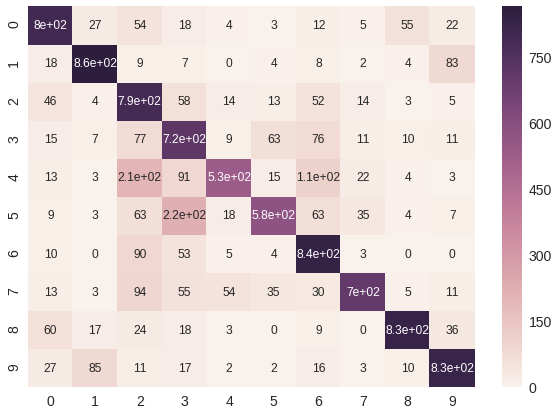

In [36]:
# Prediction
y_pred = model.predict(data.X_test)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(data.y_test, y_pred)

# Visualizing of confusion matrix  
df_cm = pd.DataFrame(cm, range(10), range(10))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})
plt.show()

In [0]:
confusion_matrix?

### Functional Model API 
Esta te permite poder crear modelos mas complejos que Sequential

In [0]:
def CNN_Model(input_shape):
  
    Img_input= Input(input_shape)   
    # Aquitecture
    x = Conv2D(32,(3,3),strides= (1,1), activation = 'relu', input_shape= (32,32,3),name='conv0')(Img_input)
    x = BatchNormalization(axis=3, name='bn0')(x)
    x = Conv2D(64, (3,3), strides=(1,1), activation='relu', name='conv1')(x)
    x = BatchNormalization(axis=3, name='bn1')(x)
    x = Conv2D(128, (3,3),strides=(1,1), activation='relu',name='conv2')(x)
    x = BatchNormalization(axis=3, name='bn2')(x)
    x = MaxPooling2D(pool_size=(2,2), name='maxpool')(x)
    
    x = GlobalAveragePooling2D(name='Gavg')(x)
    x = Dense(1024,activation='relu', name='dense1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Dense(512,activation='relu',name='dense2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Dense(256, activation='relu',name='dense3')(x)
    x = Dropout(0.1, name='dropout')(x)
    y_pred = Dense(10, activation='softmax',name='feature_vector')(x)
    model= Model(inputs=Img_input, outputs=y_pred) 
    return model
    

In [0]:
modelo= CNN_Model((32,32,3))

In [0]:
modelo.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [48]:
training = modelo.fit_generator(datagen.flow(data.X_train, data.y_train, batch_size= 64, shuffle= True),
                                   steps_per_epoch=data.X_train.shape[0]//64,
                                   epochs = 20,
                                   validation_data= (data.X_test,data.y_test))

Epoch 1/10
781/781 [==============================] - 51s 65ms/step - loss: 1.8040 - acc: 0.3538 - val_loss: 1.5626 - val_acc: 0.4371
Epoch 2/10
781/781 [==============================] - 48s 62ms/step - loss: 1.4652 - acc: 0.4726 - val_loss: 2.1446 - val_acc: 0.3459
Epoch 3/10
781/781 [==============================] - 48s 61ms/step - loss: 1.3314 - acc: 0.5245 - val_loss: 1.3326 - val_acc: 0.5284
Epoch 4/10
781/781 [==============================] - 48s 62ms/step - loss: 1.2561 - acc: 0.5550 - val_loss: 1.4513 - val_acc: 0.5031
Epoch 5/10
781/781 [==============================] - 48s 62ms/step - loss: 1.1883 - acc: 0.5795 - val_loss: 1.3228 - val_acc: 0.5567
Epoch 6/10
781/781 [==============================] - 47s 61ms/step - loss: 1.1406 - acc: 0.5984 - val_loss: 1.3604 - val_acc: 0.5462
Epoch 7/10
781/781 [==============================] - 47s 60ms/step - loss: 1.0952 - acc: 0.6154 - val_loss: 1.2223 - val_acc: 0.5744
Epoch 8/10
781/781 [==============================] - 47s 60ms

### Eager Execution Model 

#### Model 

In [0]:
class Conv_Model(tf.keras.Model):
  
  def __init__(self):
    super().__init__()
    
    # Aquitecture
    self.conv1= Conv2D(32, (3,3),strides= (1,1), activation = tf.nn.relu, input_shape= (32,32,3))
    self.BatchNorm1 = BatchNormalization(axis=3)
    self.conv2= Conv2D(64, (3,3), strides=(1,1), activation=tf.nn.relu)
    self.BatchNorm2 = BatchNormalization(axis=3)
    self.conv3= Conv2D(128, (3,3),strides=(1,1), activation=tf.nn.relu)
    self.BatchNorm3 = BatchNormalization(axis=3)
    self.maxpool = MaxPooling2D(pool_size=(2,2))
    self.globalAvg = GlobalAveragePooling2D()
    self.dense1 = Dense(1024, activation=tf.nn.relu)
    self.BatchNorm4= BatchNormalization()
    self.dense2 = Dense(512,activation=tf.nn.relu)
    self.BatchNorm5 = BatchNormalization()
    self.dense3= Dense(256,activation=tf.nn.relu)
    self.dropout= Dropout(0.1)
    self.logits= Dense(10)
  
  def call(self, inputs):
    x= self.conv1(inputs)
    x= self.BatchNorm1(x)
    x= self.conv2(x)
    x= self.BatchNorm2(inputs)
    x= self.conv3(x)
    x= self.BatchNorm3(x)
    x= self.maxpool(x)
    x= self.globalAvg(x)
    x= self.dense1(x)
    x= self.BatchNorm4(x)
    x= self.dense2(x)
    x= self.BatchNorm5(x)
    x= self.dense3(x)
    x= self.dropout(x)
    output= self.logits(x)
    
    return output
  
  def predict(self,inputs):
    y_pred=self(inputs)
    return tf.argmax(y_pred, axis=-1)

  def evaluate(self, X_test, y_test):
    y_pred= self.predict(X_test).numpy()
    total_test_samples=y_test.shape[0]
    print("Validation Accuracy: %f " % (sum(y_pred==data_loader.y_test)/total_test_samples))
    

In [0]:
convModel=Conv_Model()

In [0]:
# Hyperparametros
epochs=1000
batch_size=64
learning_rate=0.001

In [0]:
# Adam Optimizer
optimizer=tf.train.AdamOptimizer(learning_rate)

#### Training

In [18]:
y.shape

(64, 1)

In [23]:
for epoch in range(epochs):
  # Datos de entrenamientp
  X,y=data.get_batch(batch_size)
  
  with tf.GradientTape() as tape:
    # forward prop
    y_pred=convModel(tf.convert_to_tensor(X))
    
    # loss function
    loss= tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_pred)
    if epoch%100==0:
      print(f'epoch: {epoch}, loss: {loss.numpy()}')
   
  # Backprop 
  grads= tape.gradient(loss, convModel.variables)
  
  # update rule (dW1, W1)
  optimizer.apply_gradients(grads_and_vars=zip(grads,convModel.variables))

epoch: 0, loss: 2.299995183944702
epoch: 100, loss: 2.1629436016082764
epoch: 200, loss: 1.757750153541565
epoch: 300, loss: 1.763550043106079
epoch: 400, loss: 1.7612206935882568
epoch: 500, loss: 1.789049744606018
epoch: 600, loss: 1.8878310918807983
epoch: 700, loss: 1.8299998044967651
epoch: 800, loss: 1.6959118843078613
epoch: 900, loss: 1.661496877670288


## Transfer Learning


#### Download Data 

In [0]:
! mkdir data && wget http://files.fast.ai/data/dogscats.zip && unzip dogscats.zip -d data

In [16]:
ls data/dogscats/

models/  sample/  test1/  train/  valid/


In [0]:
train_dir='data/dogscats/train'
val_dir='data/dogscats/valid'
test_dir='data/dogscats/test1'

#### Data Augmentation

In [0]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

#### Import Data

In [35]:
train_generator  = train_datagen.flow_from_directory(train_dir,
                                       target_size = (224, 224),
                                       batch_size = 64,
                                       class_mode =  "categorical")

validation_generator = test_datagen.flow_from_directory(
                                        val_dir,
                                        target_size= (224, 224),
                                        batch_size=64,
                                        class_mode= "categorical")

test_generator = test_datagen.flow_from_directory(test_dir,
                                target_size= (224, 224),
                                batch_size=64,
                                class_mode= "categorical")

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 0 images belonging to 0 classes.


####  Pre- Trained  Model MobileNetV2 

In [0]:
mobile =MobileNetV2(include_top=False, weights= 'imagenet', input_shape=(224,224,3))

In [0]:
# Model 
x = mobile.output
x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dense(1024,activation='relu')(x)
x=BatchNormalization()(x)
x= Dropout(0.5)(x)
y_pred= Dense(2, activation='softmax')(x)


In [0]:
model= Model(inputs= mobile.input, outputs=y_pred)
model.summary()

#### Fine-tuning

In [0]:
feature_vector_layer=len(mobile.layers) # 155

# Unfreeze this layers 
for layers in model.layers[:feature_vector_layer]:
    layers.trainable=False
    
# Train these layers
for layers in model.layers[feature_vector_layer:]:
    layers.trainable=True

#### Trainig

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])

In [0]:
# Hyperparameters
batch_size=64
num_classes=2
epochs=3
n_train_samples=6000
n_val_samples=1000
n_test_samples=200

In [57]:
checkpoint = ModelCheckpoint(filepath = 'dogscats_xception.h5',
                            verbose = 1,
                            save_best_only = True,
                            monitor = 'val_acc')

early = EarlyStopping(monitor='val_acc', min_delta = 0, patience =5,verbose=1, mode ='auto')

training = model.fit_generator(
        train_generator,
        steps_per_epoch = n_train_samples // batch_size,
        epochs= epochs,
        validation_data=validation_generator,
        validation_steps = n_val_samples // batch_size,
        callbacks = [checkpoint,early])

Epoch 1/3
92/93 [============================>.] - ETA: 0s - loss: 0.2576 - acc: 0.9351
Epoch 00001: val_acc improved from -inf to 0.95208, saving model to dogscats_xception.h5
93/93 [==============================] - 134s 1s/step - loss: 0.2591 - acc: 0.9348 - val_loss: 0.1362 - val_acc: 0.9521
Epoch 2/3
92/93 [============================>.] - ETA: 0s - loss: 0.1451 - acc: 0.9509
Epoch 00002: val_acc improved from 0.95208 to 0.96042, saving model to dogscats_xception.h5
93/93 [==============================] - 83s 897ms/step - loss: 0.1447 - acc: 0.9509 - val_loss: 0.1531 - val_acc: 0.9604
Epoch 3/3
92/93 [============================>.] - ETA: 0s - loss: 0.1235 - acc: 0.9565
Epoch 00003: val_acc did not improve from 0.96042
93/93 [==============================] - 89s 956ms/step - loss: 0.1234 - acc: 0.9563 - val_loss: 0.1822 - val_acc: 0.9521


In [0]:
def plot_model_training(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

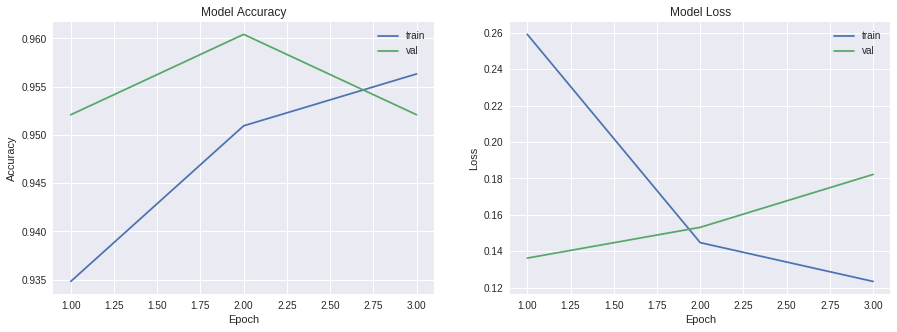

In [62]:
plot_model_training(training)